# Score Comparison
This notebook compares scaffold promiscuity scores (pscores) between badapple_classic and badapple2 DBs.

Note that scaffolds which have a score of 'None' are marked with a score of -1.0. If a given scaffold has a score of 'None' in **both** DBs then it is dropped before calculating metrics, otherwise it is kept.

## Setup

In [ ]:
# define DB variables
ORIGINAL_DB_NAME = "badapple_classic"
ORIGINAL_DB_HOST = "localhost"
ORIGINAL_DB_USER = "<your_user>"
ORIGINAL_DB_PASSWORD = "<your_password>"

COMPARISON_DB_NAME = "badapple2"
COMPARISON_DB_HOST = ORIGINAL_DB_HOST
COMPARISON_DB_USER = ORIGINAL_DB_USER
COMPARISON_DB_PASSWORD = ORIGINAL_DB_PASSWORD

In [174]:
# imports
import psycopg2
import psycopg2.extras
from psycopg2 import sql
import pandas as pd
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, PercentFormatter
import numpy as np
import seaborn as sns

## Connect to DBs

In [7]:
def db_connect(db_name: str, host: str, user: str, password: str):
    try:
        db_connection = psycopg2.connect(
            dbname=db_name,
            host=host,
            user=user,
            password=password,
            cursor_factory=psycopg2.extras.DictCursor,
        )
        db_connection.set_session(readonly=True)
        return db_connection
    except Exception as e:
        print(e)
        print(f"Error connecting to DB: {db_name}")
        return None

In [8]:
original_db_connection = db_connect(ORIGINAL_DB_NAME, ORIGINAL_DB_HOST, ORIGINAL_DB_USER, ORIGINAL_DB_PASSWORD)
comparison_db_connection = db_connect(COMPARISON_DB_NAME, COMPARISON_DB_HOST, COMPARISON_DB_USER, COMPARISON_DB_PASSWORD)

In [9]:
original_db_cur = original_db_connection.cursor()
comparison_db_cur = comparison_db_connection.cursor()

## View metadata
Medians/overall stats.

Note that in badapple2 we use the badapple_classic medians to normalize scores to ensure our criteria remains consistent (see [annotate_db_scores.py](../annotate_db_scores.py))

In [10]:
def get_summary_stats(db_cursor, db_conn):
    query = sql.SQL("SELECT median_ncpd_tested,median_nsub_tested,median_nass_tested,median_nsam_tested,nass_total FROM metadata")
    result = []
    try:
        db_cursor.execute(query)
        result = db_cursor.fetchall()
        return result[0] # only 1 row
    except Exception:
        db_conn.rollback()
    return result

In [11]:
original_stats = get_summary_stats(original_db_cur, original_db_connection)
comparison_stats = get_summary_stats(comparison_db_cur, comparison_db_connection)

In [12]:
stat_diff = list(np.array(comparison_stats) - np.array(original_stats))
columns = ["source","median_ncpd_tested","median_nsub_tested","median_nass_tested","median_nsam_tested","nass_total"]
rows = [["badapple_classsic"] + original_stats, ["badapple2"] + comparison_stats, ["diff"] + stat_diff]
summary_df = pd.DataFrame(rows, columns=columns)

In [13]:
summary_df

,source,median_ncpd_tested,median_nsub_tested,median_nass_tested,median_nsam_tested,nass_total
0,badapple_classsic,2,2,633,773,823
1,badapple2,1,2,8,11,906
2,diff,-1,0,-625,-762,83


## Get pscores of shared scaffolds

In [14]:
def get_pscores(db_cursor, db_conn):
    query = sql.SQL("SELECT scafsmi, pscore FROM scaffold order by scafsmi")
    result = []
    try:
        db_cursor.execute(query)
        result = db_cursor.fetchall()
        return result
    except Exception:
        db_conn.rollback()
    return result

In [15]:
original_pscores = get_pscores(original_db_cur, original_db_connection)
comparison_pscores = get_pscores(comparison_db_cur, comparison_db_connection)

In [16]:
def get_pscore_df(pscore_list: list[list[str, int]]):
    df = pd.DataFrame(pscore_list, columns=['scafsmi', 'pscore'])
    # some compounds have 'None' as pscore (no evidence)
    # don't drop here in case this scaffold has a different score in other DB
    df['pscore'] = df['pscore'].fillna(-1.0) 
    return df

In [17]:
original_df = get_pscore_df(original_pscores)
comparison_df = get_pscore_df(comparison_pscores)

In [18]:
# get df containing shared scaffolds
shared_df = pd.merge(original_df, comparison_df, on='scafsmi')
shared_df.rename(columns={"pscore_x": "pscore_classic", "pscore_y": "pscore_2"}, inplace=True)

# drop entries where both pscores were None
# currently not relevant since there are 0 "None" scores in badapple2
shared_df = shared_df[~((shared_df['pscore_classic'] < 0) & (shared_df['pscore_2'] < 0))]

In [19]:
shared_df

,scafsmi,pscore_classic,pscore_2
0,B1OCCO1,-1.0,0.0
1,[BH2-](c1ccccc1)c1ccccc1,10.0,3.0
2,C1C2C1C1C3CC4C(C23)C41,0.0,0.0
3,C1C2C3C4OC5C3C1C1C2C4C51,0.0,0.0
4,C1C2C3CC4C5CC(C1C35)C24,4.0,2.0
...,...,...,...
142877,S=P(NCCNP(=S)(N1CC1)N1CC1)(N1CC1)N1CC1,0.0,0.0
142878,S=P(NCCSCc1ccccc1)(N1CC1)N1CC1,1.0,1.0
142879,S=P(N=CN1CCOCC1)(N1CCOCC1)N1CCOCC1,0.0,0.0
142880,S=P(Nn1cnnc1)(c1ccccc1)c1ccccc1,0.0,0.0


## Calculate correlation, visualize with parity plot

In [20]:
def create_parity_plot(df: pd.DataFrame, x_col: str, y_col: str, title: str=None):
    plt.style.use('ggplot')
    plt.scatter(df[x_col], df[y_col], alpha=0.5)
    # Create parity line
    plt.plot(df[x_col], df[x_col], color='black')
    ax = plt.gca()
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    if title is not None:
        ax.set_title(title)
    plt.tight_layout()

In [21]:
# use scipy to calculate correlation + pval
correlation, p_value = pearsonr(shared_df["pscore_classic"], shared_df["pscore_2"])

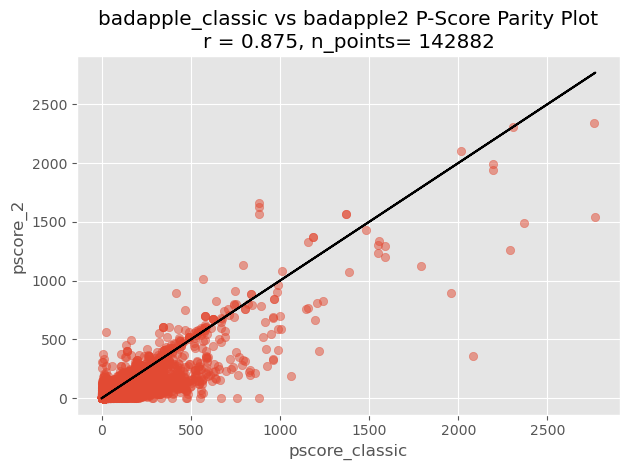

In [22]:
# visualize parity plot (with 'None' entries included)
plot_title = "badapple_classic vs badapple2 P-Score Parity Plot\nr = %.3f, n_points= %d" % (correlation, len(shared_df))
create_parity_plot(shared_df, "pscore_classic", "pscore_2", plot_title)
plt.show()

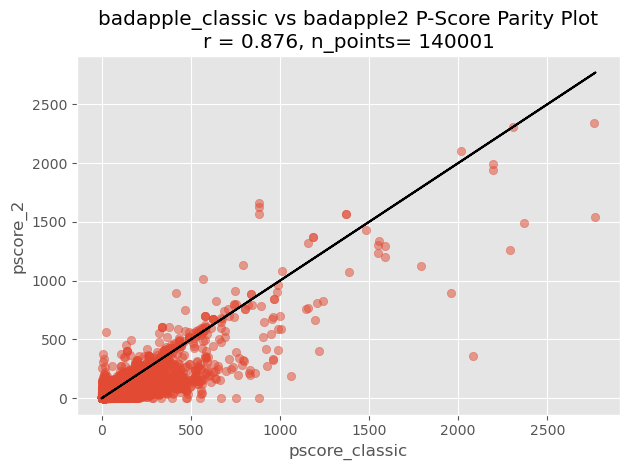

In [23]:
# parity plot (without 'None' entries from badapple_classic included)
shared_df_no_nan = shared_df[~(shared_df['pscore_classic'] < 0)]
correlation, p_value = pearsonr(shared_df_no_nan["pscore_classic"], shared_df_no_nan["pscore_2"])
plot_title = "badapple_classic vs badapple2 P-Score Parity Plot\nr = %.3f, n_points= %d" % (correlation, len(shared_df_no_nan))
create_parity_plot(shared_df_no_nan, "pscore_classic", "pscore_2", plot_title)
plt.show()

## Compare pscore rankings

In [24]:
shared_df_no_nan["classic_rank"] = shared_df_no_nan["pscore_classic"].rank()
shared_df_no_nan["2_rank"] = shared_df_no_nan["pscore_2"].rank()

/tmp/ipykernel_101960/138781182.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shared_df_no_nan["classic_rank"] = shared_df_no_nan["pscore_classic"].rank()
/tmp/ipykernel_101960/138781182.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shared_df_no_nan["2_rank"] = shared_df_no_nan["pscore_2"].rank()


In [25]:
shared_df_no_nan["rank_diff"] = shared_df_no_nan["classic_rank"] - shared_df_no_nan["2_rank"]

/tmp/ipykernel_101960/3954084723.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shared_df_no_nan["rank_diff"] = shared_df_no_nan["classic_rank"] - shared_df_no_nan["2_rank"]


In [149]:
# custom transforms to get log-like scaling on y-axis of histogram when using percentages
def loglike_formatter(y, _):
    return f"{y*100:.0f}%" if y > 0 else "0%"

def loglike_transform(y):
    return np.log10(y + 1e-6)  # Add a small value to avoid log(0)

class LogLikeScale:
    def __init__(self, transform):
        self.transform = transform
    
    def __call__(self, y):
        return self.transform(y)

def plot_histogram(df: pd.DataFrame, column: str, bins, xlabel: str, ylabel: str, title: str, yscale: str = "linear", plot_percentage: bool = False):
    data = df[column]
    weights = None
    if plot_percentage:
        weights = np.ones(len(data)) / len(data)
    plt.hist(df[column], weights=weights, bins=bins, edgecolor='black', alpha=0.7)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if plot_percentage and yscale == "log":
        plt.gca().set_yscale("function", functions=(LogLikeScale(loglike_transform), np.exp))
        plt.gca().yaxis.set_major_formatter(FuncFormatter(loglike_formatter))
    elif plot_percentage:
        plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    else:
        plt.yscale(yscale)
    title += f"\nN={len(data)}"
    plt.title(title)
    plt.show()

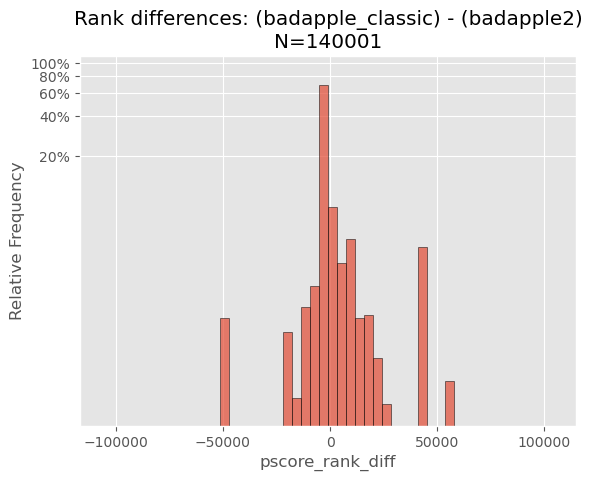

In [151]:
title = f'Rank differences: (badapple_classic) - (badapple2)'
plot_histogram(shared_df_no_nan, "rank_diff", 50, "pscore_rank_diff", "Relative Frequency", title, yscale="log", plot_percentage=True)

In [28]:
SCAF_COL_STR = "scafsmi,nsub_tested,nsub_active,nass_tested,nass_active,nsam_tested,nsam_active"
SCAF_COL_LIST = SCAF_COL_STR.split(",")

## Score histograms

In [38]:
def show_score_histogram(pscore_values: pd.Series, db_source: str):
    # Define the ranges and corresponding colors
    ranges = [(-float('inf'), 0), (0, 100), (100, 300), (300, float('inf'))]
    colors = ['grey', 'green', 'yellow', 'red']
    labels = ['pscore = ~', '0 <= pscore < 100', '100 <= pscore < 300', 'pscore >= 300']

    # Create lists to hold the pscore values for each range
    pscore_lists = [[] for _ in ranges]
    counts = [0] * len(ranges)

    # Distribute the pscore values into the corresponding lists
    for pscore in pscore_values:
        for i, (low, high) in enumerate(ranges):
            if low <= pscore < high:
                pscore_lists[i].append(pscore)
                counts[i] += 1
                break
    
    # Define the bin edges in increments of 25
    bin_size = 25
    # min score is 0
    bin_edges = np.arange(-bin_size, max(pscore_values) + bin_size, bin_size)

    # Plot the histogram
    plt.figure(figsize=(10, 6))
    for pscore_list, color in zip(pscore_lists, colors):
        plt.hist(pscore_list, bins=bin_edges, color=color, edgecolor='black', alpha=0.7)

    plt.xlabel('pscore')
    plt.ylabel('Frequency')
    plt.yscale("log")
    plt.title(f'Histogram of P-Score Values from {db_source}\nBin Size={bin_size}')

    total_count = len(pscore_values)
    pct = lambda count : "%.2f" % ((100 * count) / total_count)
    legend_labels = [f'{label} : {count} ({pct(count)}%)' for label, count in zip(labels, counts)]
    legend_title = f"Counts (Total={total_count})"
    plt.legend(legend_labels, title=legend_title, loc='upper right')

    plt.show()

### Original DB (badapple_classic)

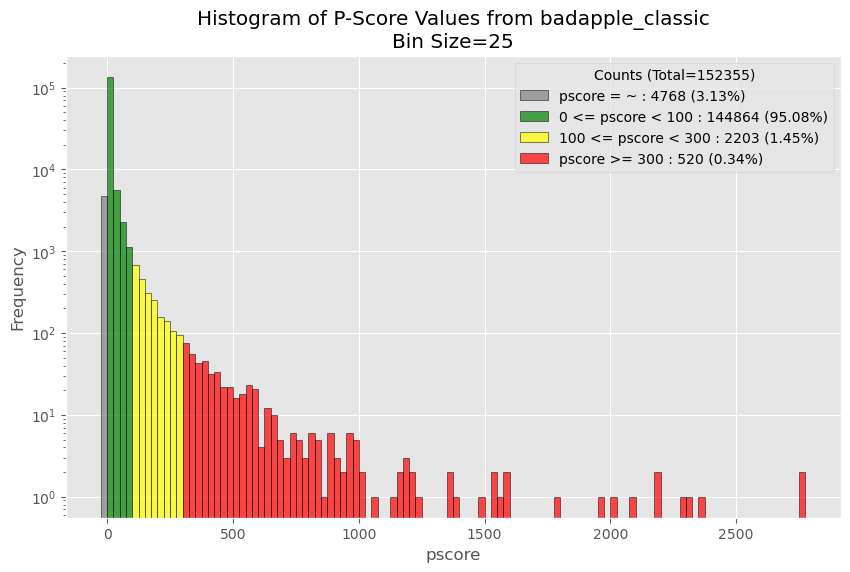

In [39]:
show_score_histogram(original_df["pscore"], "badapple_classic")

### New DB (badapple2)

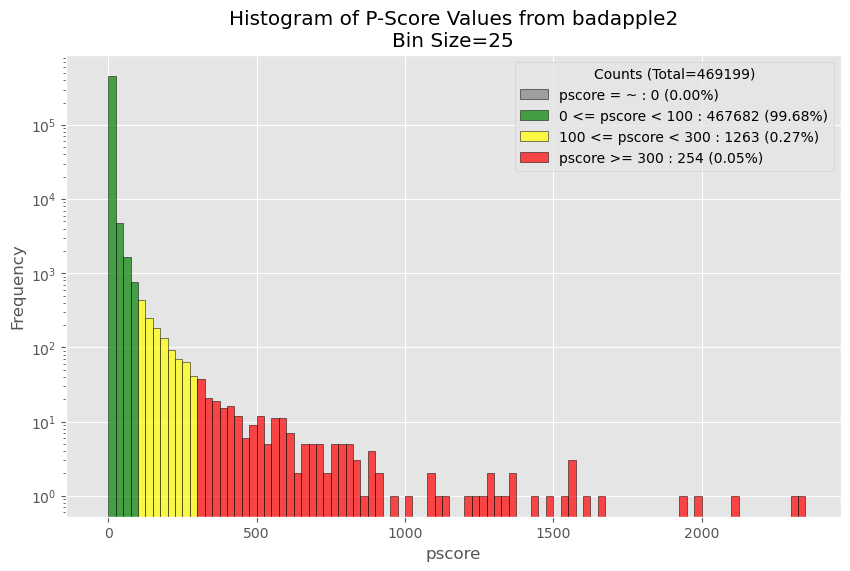

In [40]:
show_score_histogram(comparison_df["pscore"], "badapple2")

### Both
pScore histograms from shared scaffolds (combined by canonical SMILES)

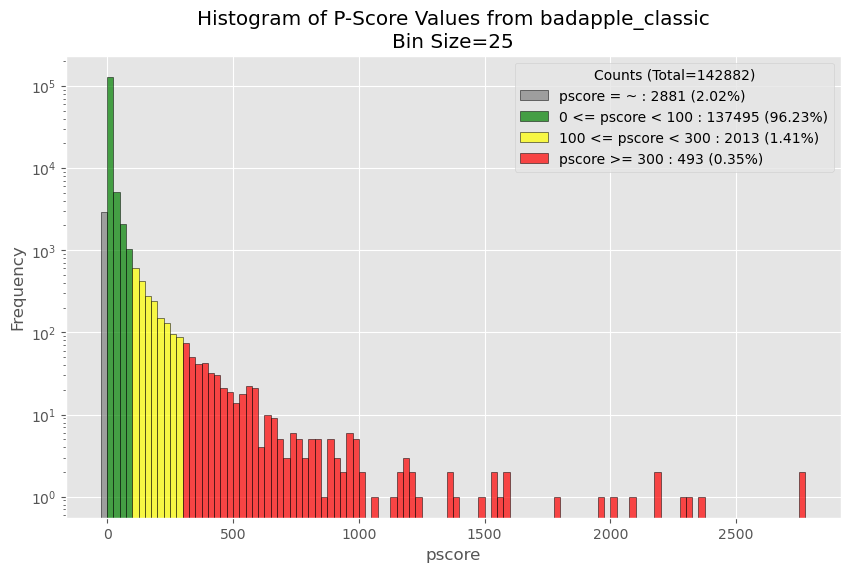

In [182]:
show_score_histogram(shared_df["pscore_classic"], "badapple_classic")

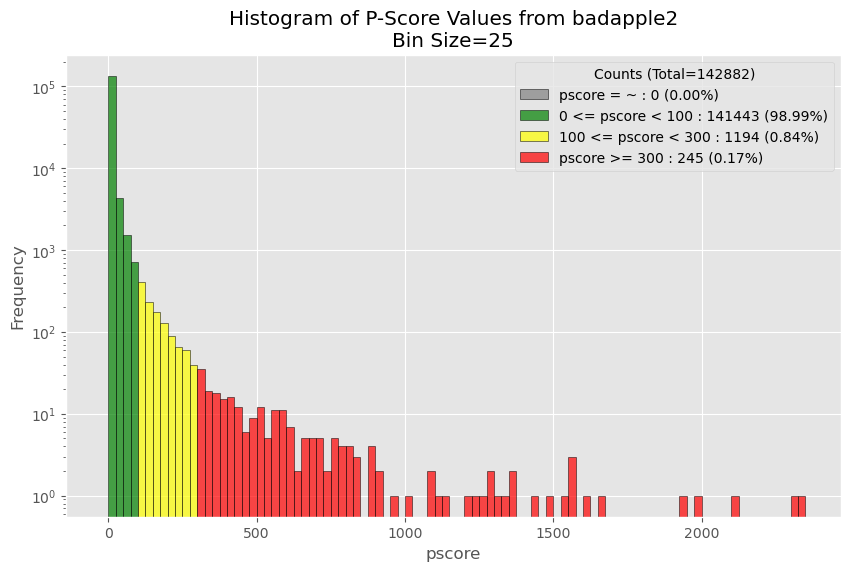

In [181]:
show_score_histogram(shared_df["pscore_2"], "badapple2")

### Difference Histogram
Visualize changes in pScore of scaffolds from badapple_classic to badapple2.

In [68]:
shared_df_no_nan["pscore_diff"] = shared_df_no_nan["pscore_classic"] - shared_df_no_nan["pscore_2"]

/tmp/ipykernel_101960/2131279566.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shared_df_no_nan["pscore_diff"] = shared_df_no_nan["pscore_classic"] - shared_df_no_nan["pscore_2"]


In [114]:
# number of entries with no pscore difference
def float_equals(a: float, b: float, epsilon: float=1e-9):
    return abs(a - b) < epsilon

no_pscore_diff_count = len(shared_df_no_nan[float_equals(shared_df_no_nan["pscore_diff"], 0)])
no_pscore_diff_pct = round((no_pscore_diff_count / len(shared_df_no_nan)) * 100.0, 2)
print(f"N. entries with no difference in pScore: {no_pscore_diff_count} ({no_pscore_diff_pct}%)")

N. entries with no difference in pScore: 88923 (63.52%)


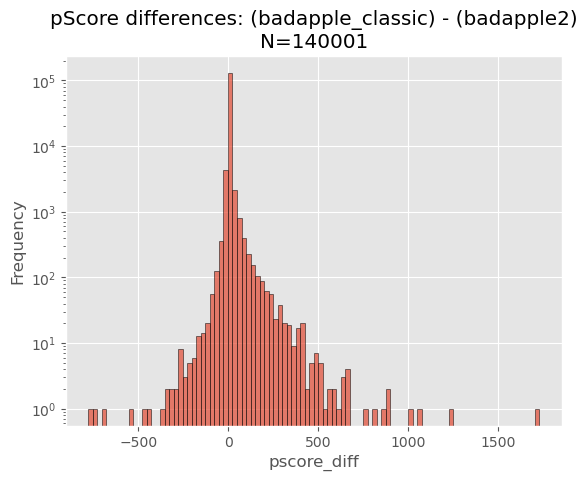

In [153]:
title = f'pScore differences: (badapple_classic) - (badapple2)'
plot_histogram(shared_df_no_nan, "pscore_diff", 100, "pscore_diff", "Frequency", title, yscale="log", plot_percentage=False)

In [123]:
# create table
pscore_diff_bins = [-10000, -500, -200, -100, -75, -50, -25, 0, 25, 50, 75, 100, 200, 500, 10000]
shared_df_no_nan["pscore_diff_bin"] = pd.cut(shared_df_no_nan["pscore_diff"], bins=pscore_diff_bins)

/tmp/ipykernel_101960/1287041227.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shared_df_no_nan["pscore_diff_bin"] = pd.cut(shared_df_no_nan["pscore_diff"], bins=pscore_diff_bins)


In [146]:
pscore_diff_vcounts = shared_df_no_nan["pscore_diff_bin"].value_counts(sort=False)
total = sum(pscore_diff_vcounts)
print(f"N={total}\n")
max_range_len = len("(-10000, -500]")
max_cnt_len = len("101685")
for pscore_range, cnt in pscore_diff_vcounts.items():
    pct = round(cnt/total * 100, 3)
    s = str(pscore_range)
    s2 = str(cnt)
    padding = " " * (max_range_len - len(s))
    padding2 = " " * (max_cnt_len - len(s2))
    print(f"{s + padding} | {s2 + padding2} | {pct}%")

N=140001

(-10000, -500] | 4      | 0.003%
(-500, -200]   | 25     | 0.018%
(-200, -100]   | 56     | 0.04%
(-100, -75]    | 63     | 0.045%
(-75, -50]     | 144    | 0.103%
(-50, -25]     | 408    | 0.291%
(-25, 0]       | 101685 | 72.632%
(0, 25]        | 33812  | 24.151%
(25, 50]       | 1860   | 1.329%
(50, 75]       | 695    | 0.496%
(75, 100]      | 386    | 0.276%
(100, 200]     | 559    | 0.399%
(200, 500]     | 277    | 0.198%
(500, 10000]   | 27     | 0.019%


### Visualize Transition Table
Cases where pScore went from "low" to moderate", "low" to "high", etc

In [180]:
def classify_pscore(pscore):
    if pscore < 100:
        return "low"
    elif pscore < 300:
        return "moderate"
    else:
        return "high"

In [161]:
# Classify the pScores for both databases
shared_df_no_nan["classic_class"] = shared_df_no_nan["pscore_classic"].apply(classify_pscore)
shared_df_no_nan["new_class"] = shared_df_no_nan["pscore_2"].apply(classify_pscore)

# Create a column for transitions
shared_df_no_nan["transition"] = shared_df_no_nan["classic_class"] + " -> " + shared_df_no_nan["new_class"]

/tmp/ipykernel_101960/4260937064.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shared_df_no_nan["classic_class"] = shared_df_no_nan["pscore_classic"].apply(classify_pscore)
/tmp/ipykernel_101960/4260937064.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shared_df_no_nan["new_class"] = shared_df_no_nan["pscore_2"].apply(classify_pscore)
/tmp/ipykernel_101960/4260937064.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

#### Bar Chart

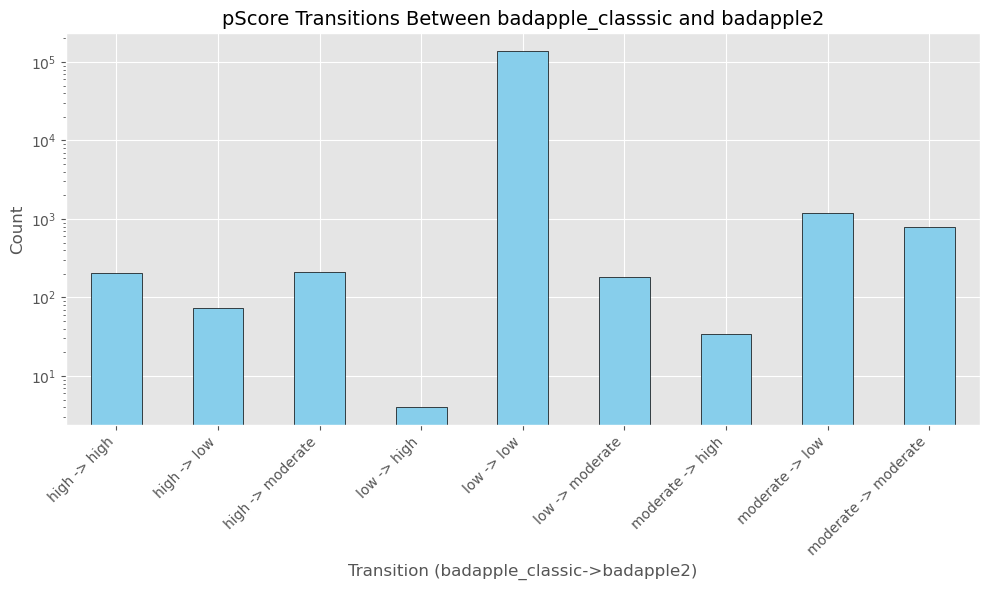

In [162]:
# Bar chart
transition_counts = shared_df_no_nan["transition"].value_counts()

# Plot the results
plt.figure(figsize=(10, 6))
transition_counts.sort_index().plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("pScore Transitions Between badapple_classsic and badapple2", fontsize=14)
plt.xlabel("Transition (badapple_classic->badapple2)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.yscale("log")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

#### Heatmap

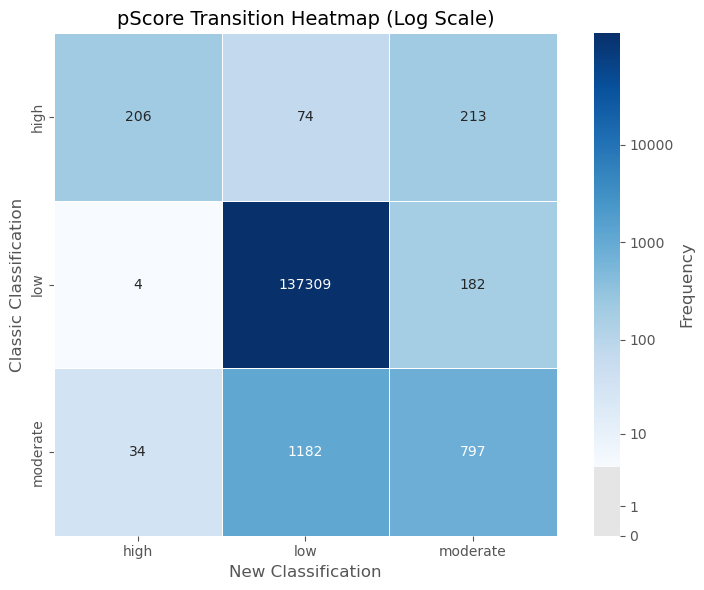

In [179]:
# Heatmap

# Create a transition matrix
transition_matrix = (
    shared_df_no_nan.groupby(["classic_class", "new_class"])
    .size()
    .unstack(fill_value=0)
)


# Logarithmic transformation of the transition matrix
log_transition_matrix = np.log1p(transition_matrix)  # log1p to handle zeros (log(1 + x))

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    log_transition_matrix,
    annot=transition_matrix,  # Show original counts as annotations
    fmt="d",
    cmap="Blues",
    cbar_kws={"label": "Frequency"},
    linewidths=0.5,
    square=True
)

# Customize the colorbar ticks
colorbar = plt.gca().collections[0].colorbar
original_ticks = [0, 1, 10, 100, 1000, 10000]
log_ticks = np.log1p(original_ticks)
colorbar.set_ticks(log_ticks)
colorbar.set_ticklabels(original_ticks)

plt.title("pScore Transition Heatmap (Log Scale)", fontsize=14)
plt.xlabel("New Classification", fontsize=12)
plt.ylabel("Classic Classification", fontsize=12)
plt.tight_layout()
plt.show()

## Compare "batting averages" between the two DBs
Here "batting average" refers to the (non-normalized) ratio of
active/tested statistics for substances,assays, and wells (ie samples).

In [54]:
def compute_batting_avg(
    row
) -> float:
    sTested = row["nsub_tested"]
    sActive = row["nsub_active"]
    aTested = row["nass_tested"]
    aActive = row["nass_active"]
    wTested = row["nsam_tested"]
    wActive = row["nsam_active"]
    if sTested == 0 or aTested == 0 or wTested == 0:
        return None  # None means no evidence

    batting_avg = (
        1.0
        * sActive
        / (sTested)
        * aActive
        / (aTested)
        * wActive
        / (wTested)
    )
    return batting_avg

In [55]:
def get_scaf_stats(db_cursor, db_conn):
    query = sql.SQL(f"SELECT {SCAF_COL_STR} FROM scaffold order by scafsmi")
    result = []
    try:
        db_cursor.execute(query)
        result = db_cursor.fetchall()
        return result
    except Exception as e:
        print(e)
        db_conn.rollback()
    return result

In [56]:
def get_batting_avg_df(pscore_list: list[list[str, int]]):
    df = pd.DataFrame(pscore_list, columns=SCAF_COL_LIST)
    df["batting_avg"] = df.apply(compute_batting_avg, axis=1)
    df.dropna(subset="batting_avg", inplace=True)
    return df

In [32]:
original_scaf_stats = get_scaf_stats(original_db_cur, original_db_connection)
comparison_scaf_stats = get_scaf_stats(comparison_db_cur, comparison_db_connection)

In [57]:
original_batting_avg_df = get_batting_avg_df(original_scaf_stats)
comparison_batting_avg_df = get_batting_avg_df(comparison_scaf_stats)

In [58]:
# remove stats
original_batting_avg_df = original_batting_avg_df[["scafsmi", "batting_avg"]]
comparison_batting_avg_df = comparison_batting_avg_df[["scafsmi", "batting_avg"]]

In [ ]:
# get df containing shared scaffolds
shared_batting_avg_df = pd.merge(original_batting_avg_df, comparison_batting_avg_df, on='scafsmi')
shared_batting_avg_df.rename(columns={"batting_avg_x": "batting_avg_classic", "batting_avg_y": "batting_avg_2"}, inplace=True)

### Histogram

In [ ]:
original_batting_avg_df

### Parity Plot

In [ ]:
# use scipy to calculate correlation + pval
correlation_nn, p_value_nn = pearsonr(shared_batting_avg_df["batting_avg_classic"], shared_batting_avg_df["batting_avg_2"])

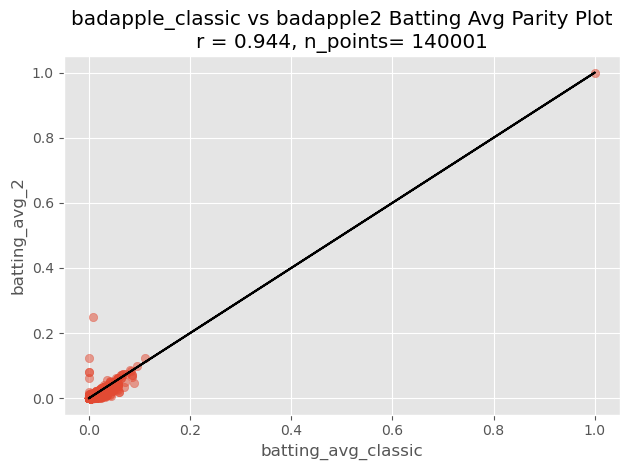

In [61]:
# visualize parity plot
plot_title = "badapple_classic vs badapple2 Batting Avg Parity Plot\nr = %.3f, n_points= %d" % (correlation_nn, len(shared_batting_avg_df))
create_parity_plot(shared_batting_avg_df, "batting_avg_classic", "batting_avg_2", plot_title)
plt.show()

## Compare "InDrug" Scores
This section compares the scores for scaffolds which were found to be present in approved drugs from [DrugCentral](https://drugcentral.org/).

### Get pscores of indrug scaffolds

In [41]:
def get_pscores_ind(db_cursor, db_conn):
    query = sql.SQL("SELECT scafsmi, pscore FROM scaffold WHERE in_drug ORDER BY scafsmi")
    result = []
    try:
        db_cursor.execute(query)
        result = db_cursor.fetchall()
        return result
    except Exception:
        db_conn.rollback()
    return result

In [42]:
original_pscores_ind = get_pscores_ind(original_db_cur, original_db_connection)
comparison_pscores_ind = get_pscores_ind(comparison_db_cur, comparison_db_connection)

In [43]:
original_df_ind = get_pscore_df(original_pscores_ind)
comparison_df_ind = get_pscore_df(comparison_pscores_ind)

In [44]:
# get df containing shared scaffolds
shared_df_ind = pd.merge(original_df_ind, comparison_df_ind, on='scafsmi')
shared_df_ind.rename(columns={"pscore_x": "pscore_classic", "pscore_y": "pscore_2"}, inplace=True)

# drop entries where both pscores were None
shared_df_ind = shared_df_ind[~((shared_df_ind['pscore_classic'] < 0) & (shared_df['pscore_2'] < 0))]

/tmp/ipykernel_101960/2706409221.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  shared_df_ind = shared_df_ind[~((shared_df_ind['pscore_classic'] < 0) & (shared_df['pscore_2'] < 0))]


In [45]:
shared_df_ind

,scafsmi,pscore_classic,pscore_2
0,C1=C2c3cccc4[nH]cc(c34)CC2NCC1,280.0,186.0
1,C1C2CC3CC1CC(C2)C3,229.0,56.0
2,c1c2c(cc3c1OCO3)CCCC2,1.0,0.0
3,c1c2c(cc3c1OCO3)CNCC2,2.0,2.0
4,C1=C2CCC3C4CCCC4CCC3C2Cc2cnoc21,3.0,3.0
...,...,...,...
2222,S=C(Nc1ccccc1)Oc1ccc2ccccc2c1,1.0,0.0
2223,S=C(Nc1ccccn1)Oc1ccc2c(c1)CCCC2,-1.0,0.0
2224,S=C(Nc1ccc(Nc2ccccc2)cc1)N1CCNCC1,0.0,0.0
2225,S=[PH](N1CC1)N1CC1,10.0,7.0


### Parity Plot for shared indrug scafs

In [46]:
# use scipy to calculate correlation + pval
correlation_ind, p_value_ind = pearsonr(shared_df_ind["pscore_classic"], shared_df_ind["pscore_2"])

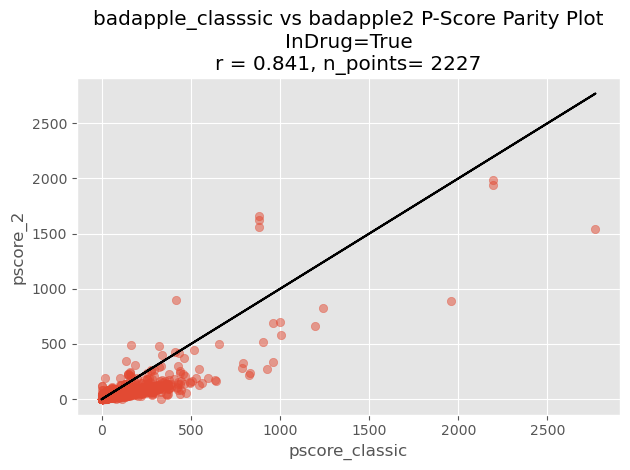

In [47]:
# visualize parity plot
plot_title = "badapple_classsic vs badapple2 P-Score Parity Plot\nInDrug=True\nr = %.3f, n_points= %d" % (correlation_ind, len(shared_df_ind))
create_parity_plot(shared_df_ind, "pscore_classic", "pscore_2", plot_title)
plt.show()

### Histogram of scores

#### Original DB (badapple_classic)

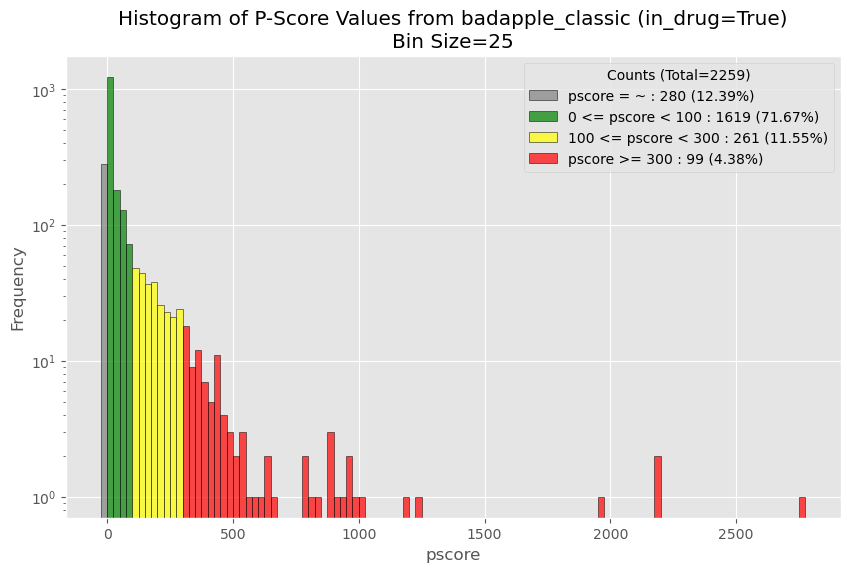

In [48]:
show_score_histogram(original_df_ind["pscore"], "badapple_classic (in_drug=True)")

#### New DB (badapple2)

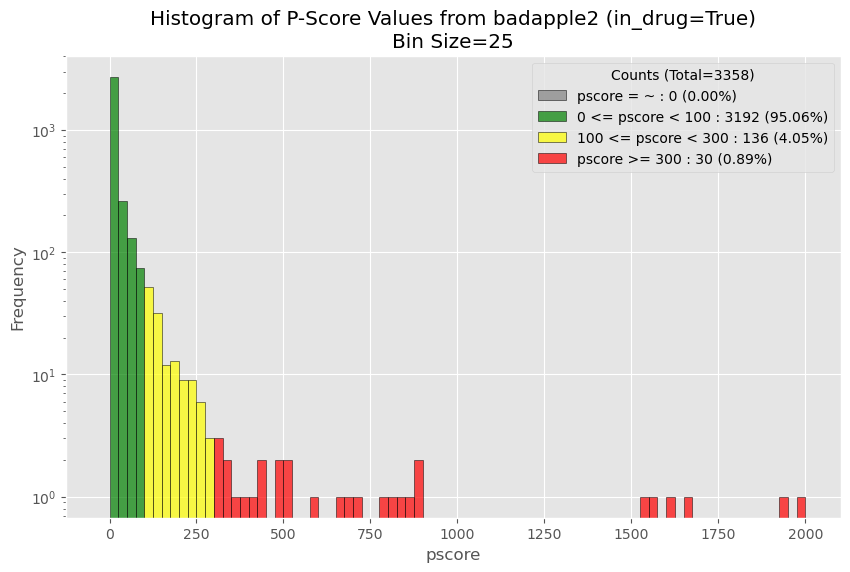

In [49]:
show_score_histogram(comparison_df_ind["pscore"], "badapple2 (in_drug=True)")

## Close DB connections

In [50]:
# Close the cursors
original_db_cur.close()
comparison_db_cur.close()

# Close the connections
original_db_connection.close()
comparison_db_connection.close()